In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from scipy import io
import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import pdb

In [3]:
# Specify which GPU to be used
device = torch.device('cuda:0')

In [4]:
# Load training dataset
dataset = io.loadmat('Data/Cylinder_Training_Dataset.mat')
training_syn_dataset = torch.tensor(dataset['dataset_training'])
training_syn_dataset = np.expand_dims(training_syn_dataset,1)
training_syn_dataset = torch.tensor(training_syn_dataset)

training_mask = torch.tensor(dataset['dataset_mask'])
training_mask = np.expand_dims(training_mask,1)
training_mask = torch.tensor(training_mask)


training_label = torch.tensor(dataset['dataset_label'])
training_label = np.expand_dims(training_label,1)
training_label = torch.tensor(training_label)

In [5]:
# Patch the training dataset 11 by 11
kernel_h, kernel_w = 11, 11
step, n_channels = 1, 1
training_syn_dataset_patch = np.array(training_syn_dataset.unfold(2, kernel_h, step).unfold(3, kernel_w, step).permute(2, 3, 0, 1, 4, 5).reshape(-1, n_channels, kernel_h, kernel_w))

training_mask_patch = np.array(training_mask.unfold(2, kernel_h, step).unfold(3, kernel_w, step).permute(2, 3, 0, 1, 4, 5).reshape(-1, n_channels, kernel_h, kernel_w))

training_label_patch = training_label.unfold(2, kernel_h, step).unfold(3, kernel_w, step).permute(2, 3, 0, 1, 4, 5).reshape(-1, n_channels, kernel_h, kernel_w)
training_label_patch = np.array(training_label_patch[:,:,5,5])

In [6]:
from numba import jit

@jit(nopython=True)        
def add_noise(x):
    noise = np.random.normal(0,0.013,x.shape)
    return x+noise

@jit(nopython=True)        
def add_bias(x, nor_factor):
    bias = nor_factor*np.abs(x+(0.1*np.random.rand(1)))*np.exp(1j*np.angle(x))
    return bias

@jit(nopython=True)        
def add_noise_to_complex(x,y):
    z = (add_noise(np.real(x))+1j*add_noise(np.imag(x)))*y
    return z    

@jit(nopython=True)        
def combine_final(x,y):
    nor_factor = (1.3-0.7)*np.random.rand(1)+ 0.7
    xx = add_noise_to_complex(add_bias(x,nor_factor), y)
    z = np.concatenate(((np.abs(xx)/nor_factor)*y, ((np.angle(xx)/2) - np.min((np.angle(xx)/2)))*y),0)
    return z    

In [7]:
class Custom_dataset(Dataset):
    def __init__(self,training_syn_dataset_patch):
        self.training_syn_dataset_patch = (training_syn_dataset_patch)
        self.training_mask_patch = (training_mask_patch)

    def __len__(self):
        
   
        return len(self.training_syn_dataset_patch)
    
               
    def __getitem__(self,idx):
        x = combine_final(self.training_syn_dataset_patch[idx], training_mask_patch[idx])
        y = training_label_patch[idx] 
        return x,y

dataset = Custom_dataset(training_syn_dataset_patch)
dataloader = DataLoader(dataset,batch_size= 100000,shuffle=True)

In [8]:
# Network
class EPT_Model(nn.Module):
    def __init__(self):
        super(EPT_Model, self).__init__()     
        self.fc = nn.Sequential(
            nn.Linear(242, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
            
    def forward(self,x):
        return self.fc(x.view(-1,242))
    
model = EPT_Model().to(device)
print(model)

EPT_Model(
  (fc): Sequential(
    (0): Linear(in_features=242, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=512, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [9]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


loss_function = []
dir_checkpoint = 'Training_loss/'

In [10]:
# Specify the Training Epoch
max_epochs = 150

In [11]:
for epoch in tqdm(range(max_epochs)):
    total_loss = 0
    model.train()
    
    for x,y in dataloader:        
        optimizer.zero_grad()
        output = 2*model(x.to(device).float())
        loss = criterion(output,y.to(device).float())
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()*x.size(0)/len(dataloader.dataset)
    loss_function.append(total_loss)
    
    if (epoch+1) % 10 == 0:
        try:
            os.mkdir(dir_checkpoint)
        except OSError:
            pass
        torch.save(model.state_dict(), dir_checkpoint + f'Cylinder_Example_Epoch__{epoch + 1}.pth')

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [58:27<00:00, 23.38s/it]


In [12]:
# Network
class EPT_Model(nn.Module):
    def __init__(self):
        super(EPT_Model, self).__init__()     
        self.fc = nn.Sequential(
            nn.Linear(242, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
            
    def forward(self,x):
        return self.fc(x.view(-1,242))
    
model = EPT_Model().cpu()
print(model)

EPT_Model(
  (fc): Sequential(
    (0): Linear(in_features=242, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0, inplace=False)
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
    (12): Linear(in_features=512, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


In [13]:
model.load_state_dict(torch.load("Training_loss/Cylinder_Example_Epoch__150.pth"))

<All keys matched successfully>

In [14]:
#Load test dataset
dataset = io.loadmat('Data/Cylinder_Test_Dataset.mat')
testing_dataset = torch.tensor(dataset['dataset_test'])
testing_dataset = np.expand_dims(testing_dataset,1)
testing_dataset = np.array(testing_dataset)

testing_mask = torch.tensor(dataset['dataset_mask_test'])
testing_mask = np.expand_dims(testing_mask,1)
testing_mask = np.array(testing_mask)

testing_GTC = torch.tensor(dataset['dataset_label_test'])
testing_GTC = torch.squeeze(testing_GTC).unsqueeze(-1)

testing_dataset = torch.tensor(add_noise_to_complex(testing_dataset,testing_mask))
testing_mask = torch.tensor(testing_mask)

testing_mask_inner = torch.tensor(dataset['dataset_Mask_Inner'])
testing_mask_inner = torch.squeeze(testing_mask_inner).unsqueeze(-1)

testing_mask_outer = torch.tensor(dataset['dataset_Mask_Outer'])
testing_mask_outer = torch.squeeze(testing_mask_outer).unsqueeze(-1)

In [15]:
# Patch the dataset 11 by 11
kernel_h, kernel_w = 11, 11
step, n_channels = 1, 1
testing_dataset_patch = np.array(testing_dataset.unfold(2, kernel_h, step).unfold(3, kernel_w, step).permute(2, 3, 0, 1, 4, 5).reshape(-1, n_channels, kernel_h, kernel_w))
testing_mask_patch = np.array(testing_mask.unfold(2, kernel_h, step).unfold(3, kernel_w, step).permute(2, 3, 0, 1, 4, 5).reshape(-1, n_channels, kernel_h, kernel_w))
testing_dataset_patch_magnitude = np.abs(testing_dataset_patch)
testing_dataset_patch_angle = np.angle(testing_dataset_patch)

In [16]:
#Phase Normalization
[az,ch,ax,ay]=testing_dataset_patch_angle.shape
testing_dataset_patch_angle_norm = np.zeros_like(testing_dataset_patch_angle)
for sslice in range(az):
    testing_dataset_patch_angle_norm[sslice] = np.squeeze(testing_dataset_patch_angle[sslice,:,:,:]/2 - np.min(testing_dataset_patch_angle[sslice,:,:,:]/2))

In [17]:
# Compose the input data
testing_dataset_patch_magnitude = testing_dataset_patch_magnitude * testing_mask_patch
testing_dataset_patch_angle_norm = testing_dataset_patch_angle_norm * testing_mask_patch

# Convert numpy arrays to PyTorch tensors
testing_dataset_patch_magnitude_tensor = torch.tensor(testing_dataset_patch_magnitude)
testing_dataset_patch_angle_norm_tensor = torch.tensor(testing_dataset_patch_angle_norm)

# Concatenate tensors along dimension 1
testing_dataset_norm = torch.cat((testing_dataset_patch_magnitude_tensor, testing_dataset_patch_angle_norm_tensor), 1)

In [18]:
#Test the input data on the network
result = 2*model(testing_dataset_norm.float())
result = torch.reshape(result, (118, 118, 1)).squeeze()
result = F.pad(result, (5, 5, 5, 5), mode='constant', value=0).unsqueeze(-1)

In [19]:
#Functions to compute mean & std values for mask information

def masked_mean(input, mask_inf):
    mask = mask_inf == 1
    masked_tensor = torch.masked_select(input, mask)
    mean_value = masked_tensor.mean()
    return mean_value

def masked_std(input, mask_inf):
    mask = mask_inf == 1
    masked_tensor = torch.masked_select(input, mask)
    std_value = masked_tensor.std()
    return std_value

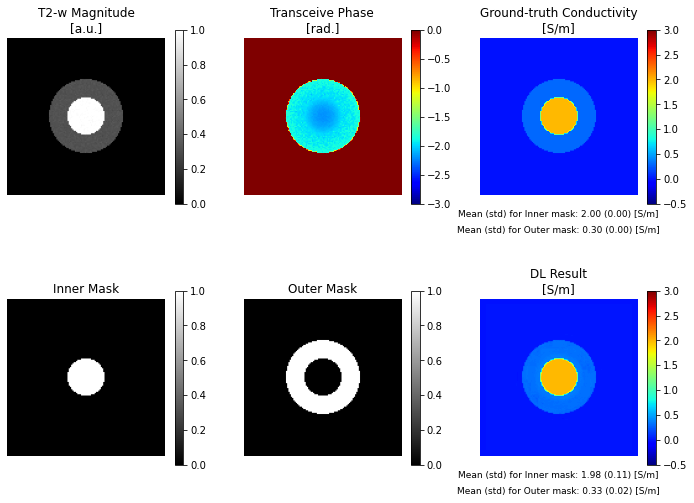

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

detached_result = result.clone().detach()
testing_mask_figure = torch.squeeze(testing_mask).unsqueeze(-1)

#Evaluate the result (Mean & std values for each mask information)
mean_value_inner_DL = masked_mean(detached_result, testing_mask_inner)
std_value_inner_DL = masked_std(detached_result, testing_mask_inner)
mean_value_inner_GTC = masked_mean(testing_GTC, testing_mask_inner)
std_value_inner_GTC = masked_std(testing_GTC, testing_mask_inner)

mean_value_outer_DL = masked_mean(detached_result, testing_mask_outer)
std_value_outer_DL = masked_std(detached_result, testing_mask_outer)
mean_value_outer_GTC = masked_mean(testing_GTC, testing_mask_outer)
std_value_outer_GTC = masked_std(testing_GTC, testing_mask_outer)


image1 = axes[0, 0].imshow(torch.abs(torch.squeeze(testing_dataset)), cmap='gray', vmin=0, vmax=1)
axes[0, 0].axis('off')
axes[0, 0].set_title('T2-w Magnitude\n[a.u.]')
bar1 = plt.colorbar(image1, ax=axes[0, 0])

image2 = axes[0, 1].imshow(torch.angle(torch.squeeze(testing_dataset)), cmap='jet', vmin=-3, vmax=0)
axes[0, 1].axis('off')
axes[0, 1].set_title('Transceive Phase\n[rad.]')
bar2 = plt.colorbar(image2, ax=axes[0, 1])

image3 = axes[0, 2].imshow((testing_GTC), cmap='jet', vmin=-0.5, vmax=3)
axes[0, 2].axis('off')
axes[0, 2].set_title('Ground-truth Conductivity\n[S/m]')
bar3 = plt.colorbar(image3, ax=axes[0, 2])
axes[0, 2].text(0.5, -0.15, "Mean (std) for Inner mask: {:.2f} ({:.2f}) [S/m]".format(mean_value_inner_GTC, std_value_inner_GTC), fontsize=9, ha='center', va='bottom', transform=axes[0, 2].transAxes)
axes[0, 2].text(0.5, -0.25, "Mean (std) for Outer mask: {:.2f} ({:.2f}) [S/m]".format(mean_value_outer_GTC, std_value_outer_GTC), fontsize=9, ha='center', va='bottom', transform=axes[0, 2].transAxes)

image4 = axes[1, 0].imshow((testing_mask_inner), cmap='gray', vmin=0, vmax=1)
axes[1, 0].axis('off')
axes[1, 0].set_title('Inner Mask')
bar4 = plt.colorbar(image4, ax=axes[1, 0])

image5 = axes[1, 1].imshow((testing_mask_outer), cmap='gray', vmin=0, vmax=1)
axes[1, 1].axis('off')
axes[1, 1].set_title('Outer Mask')
bar5 = plt.colorbar(image5, ax=axes[1, 1])

image6 = axes[1, 2].imshow((detached_result), cmap='jet', vmin=-0.5, vmax=3)
axes[1, 2].axis('off')
axes[1, 2].set_title('DL Result\n[S/m]')
bar6 = plt.colorbar(image6, ax=axes[1, 2])
axes[1, 2].text(0.5, -0.15, "Mean (std) for Inner mask: {:.2f} ({:.2f}) [S/m]".format(mean_value_inner_DL, std_value_inner_DL), fontsize=9, ha='center', va='bottom', transform=axes[1, 2].transAxes)
axes[1, 2].text(0.5, -0.25, "Mean (std) for Outer mask: {:.2f} ({:.2f}) [S/m]".format(mean_value_outer_DL, std_value_outer_DL), fontsize=9, ha='center', va='bottom', transform=axes[1, 2].transAxes);